In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shap.datasets import boston
from sklearn.linear_model import Ridge
from ensemble import Ensemble, mean_squared_error, mean_absolute_error

In [2]:
# Load data
X, Y = boston()
X = X.values
print(f'X.shape = {X.shape}, Y.shape = {Y.shape}')

# Split into training, val, test
val_portion = 0.2
test_portion = 0.2

# Shuffle inds
np.random.seed(0)
inds = np.arange(len(X))
np.random.shuffle(inds)
num_val = int(len(X) * val_portion)
num_test = int(len(X) * test_portion)

# Apply split
X_val, Y_val = X[:num_val], Y[:num_val]
X_test, Y_test = X[num_val:num_val+num_test], Y[num_val:num_val+num_test]
X_train, Y_train = X[num_val+num_test:], Y[num_val+num_test:]
del X, Y
print(f'train examples = {len(X_train)}, val examples = {len(X_val)}, test examples = {len(X_test)}')

X.shape = (506, 13), Y.shape = (506,)
train examples = 304, val examples = 101, test examples = 101


In [3]:
# Train models with random feature subsets
np.random.seed(0)
num_features = 5
num_models = 10
models = []
for _ in range(num_models):
    # Generate feature mask
    inds = np.random.choice(X_train.shape[1], num_features, replace=False)
    mask = np.zeros(X_train.shape[1])
    mask[inds] = 1
    
    # Train model
    model = Ridge(alpha=0.1)
    model.fit(X_train * mask, Y_train)
    models.append(model)

In [4]:
# Calculate performance metrics for each model
for model in models:
    # Training performance
    preds = model.predict(X_train)
    train_mse = mean_squared_error(preds, Y_train)
    train_mae = mean_absolute_error(preds, Y_train)

    # Validation performance
    preds = model.predict(X_val)
    val_mse = mean_squared_error(preds, Y_val)
    val_mae = mean_absolute_error(preds, Y_val)
    print(f'Train MSE = {train_mse:.2f}, train MAE = {train_mae:.2f}, val MSE = {val_mse:.2f}, val MAE = {val_mae:.2f}')

Train MSE = 55.81, train MAE = 5.25, val MSE = 35.13, val MAE = 4.64
Train MSE = 43.33, train MAE = 4.49, val MSE = 13.49, val MAE = 3.01
Train MSE = 54.35, train MAE = 5.26, val MSE = 23.84, val MAE = 3.71
Train MSE = 44.18, train MAE = 4.48, val MSE = 13.97, val MAE = 2.91
Train MSE = 46.61, train MAE = 4.54, val MSE = 10.85, val MAE = 2.69
Train MSE = 35.67, train MAE = 4.33, val MSE = 10.87, val MAE = 2.80
Train MSE = 34.64, train MAE = 4.26, val MSE = 23.73, val MAE = 3.82
Train MSE = 54.58, train MAE = 5.20, val MSE = 35.56, val MAE = 4.66
Train MSE = 33.65, train MAE = 4.09, val MSE = 17.39, val MAE = 3.25
Train MSE = 58.46, train MAE = 5.43, val MSE = 36.31, val MAE = 4.61


In [5]:
# Aggregate validation and test predictions
val_preds = {f'Ridge ({i})': model.predict(X_val) for i, model in enumerate(models)}
test_preds = {f'Ridge ({i})': model.predict(X_test) for i, model in enumerate(models)}

# Evaluate models in isolation
val_mse = {name: mean_squared_error(preds, Y_val) for name, preds in val_preds.items()}
val_mae = {name: mean_absolute_error(preds, Y_val) for name, preds in val_preds.items()}
test_mse = {name: mean_squared_error(preds, Y_test) for name, preds in test_preds.items()}
test_mae = {name: mean_absolute_error(preds, Y_test) for name, preds in test_preds.items()}

In [6]:
# Create ensemble
ensemble = Ensemble('reg:mse', 'simplex')

# Generate predictions using uniform weighting
ensemble_val_preds = ensemble.predict(val_preds.values())
ensemble_test_preds = ensemble.predict(test_preds.values())

[Easy-Ensemble]: Defaulting to evenly weighted ensemble. Use the `fit` function to optimize the ensemble


In [7]:
# Evaluate simple ensemble
ensemble_val_mse = mean_squared_error(ensemble_val_preds, Y_val)
ensemble_val_mae = mean_absolute_error(ensemble_val_preds, Y_val)
val_mse['Uniform Ensemble'] = ensemble_val_mse
val_mae['Uniform Ensemble'] = ensemble_val_mae

ensemble_test_mse = mean_squared_error(ensemble_test_preds, Y_test)
ensemble_test_mae = mean_absolute_error(ensemble_test_preds, Y_test)
test_mse['Uniform Ensemble'] = ensemble_test_mse
test_mae['Uniform Ensemble'] = ensemble_test_mae

In [8]:
# Fit the ensemble
ensemble.fit(val_preds.values(), Y_val)

# Generate validation and test predictions
ensemble_val_preds = ensemble.predict(val_preds.values())
ensemble_test_preds = ensemble.predict(test_preds.values())

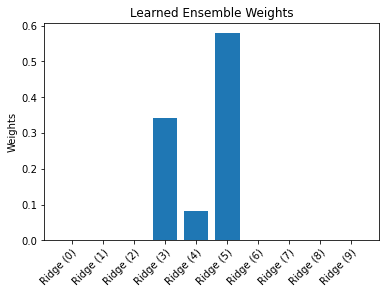

In [9]:
# Plot learned weights
plt.figure()
plt.bar(range(len(models)), ensemble.weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Learned Ensemble Weights')
plt.ylabel('Weights')
plt.show()

In [10]:
# Calculate learned ensemble performance
ensemble_val_mse = mean_squared_error(ensemble_val_preds, Y_val)
ensemble_val_mae = mean_absolute_error(ensemble_val_preds, Y_val)
val_mse['Learned Ensemble'] = ensemble_val_mse
val_mae['Learned Ensemble'] = ensemble_val_mae

ensemble_test_mse = mean_squared_error(ensemble_test_preds, Y_test)
ensemble_test_mae = mean_absolute_error(ensemble_test_preds, Y_test)
test_mse['Learned Ensemble'] = ensemble_test_mse
test_mae['Learned Ensemble'] = ensemble_test_mae

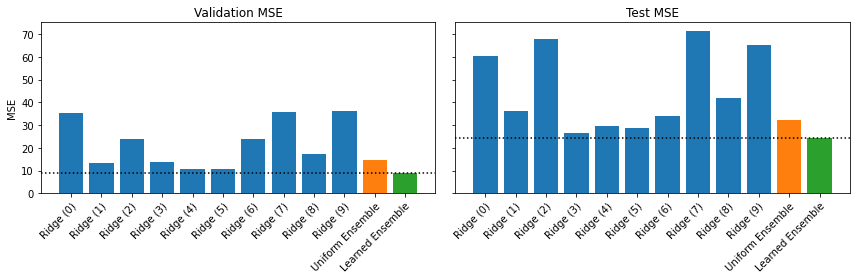

In [11]:
# Plot performance
fig, axarr = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plt.sca(axarr[0])
plt.bar(range(len(val_mse)), val_mse.values(),
        color=['C0' for _ in range(len(val_mse) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(val_mse)), val_mse.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(val_mse['Learned Ensemble'], linestyle=':', color='black')
plt.ylabel('MSE')
plt.title('Validation MSE')

plt.sca(axarr[1])
plt.bar(range(len(test_mse)), test_mse.values(),
        color=['C0' for _ in range(len(test_mse) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(test_mse)), test_mse.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(test_mse['Learned Ensemble'], linestyle=':', color='black')
plt.title('Test MSE')

plt.tight_layout()
plt.show()

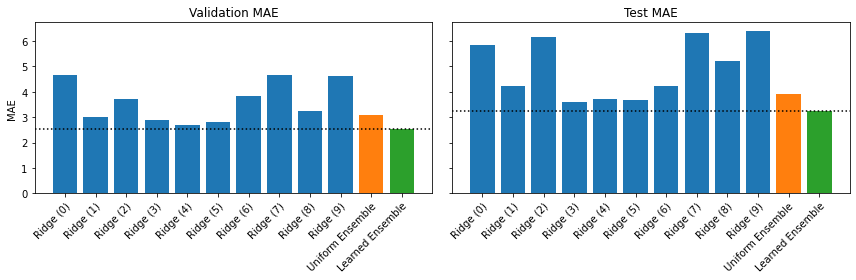

In [12]:
# Plot performance
fig, axarr = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plt.sca(axarr[0])
plt.bar(range(len(val_mae)), val_mae.values(),
        color=['C0' for _ in range(len(val_mse) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(val_mae)), val_mae.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(val_mae['Learned Ensemble'], linestyle=':', color='black')
plt.ylabel('MAE')
plt.title('Validation MAE')

plt.sca(axarr[1])
plt.bar(range(len(test_mae)), test_mae.values(),
        color=['C0' for _ in range(len(test_mae) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(test_mae)), test_mae.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(test_mae['Learned Ensemble'], linestyle=':', color='black')
plt.title('Test MAE')

plt.tight_layout()
plt.show()